## Import all depedencies

In [125]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib

In [126]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Get the key points for body pose

In [127]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils #Draw utilities 


In [128]:
def multiple_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #Color convertion 
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
    

In [129]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [130]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(51,255,51), thickness=2, circle_radius=1)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1)
                             ) 

In [131]:
cap = cv2.VideoCapture(0)


cv2.namedWindow('OpenCv feed', cv2.WINDOW_NORMAL)
cv2.resizeWindow('OpenCv feed', 1280, 720)
#cap = cv2.VideoCapture('videos/.mp4')
with mp_holistic.Holistic(min_detection_confidence=0.6,min_tracking_confidence=0.6) as holistic:
    while cap.isOpened():
    #Read frame
        ret,frame = cap.read()
        if not ret:
        # End of video
            break
    #Model predictionq
        image,results = multiple_detection(frame,holistic)
        print(results)
    # Draw landmark
        draw_styled_landmarks(image,results)
    # Show screen from user
        cv2.imshow('OpenCv feed',image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


## Extract Keypoints

In [132]:
len(results.face_landmarks.landmark)

468

In [133]:
len(results.face_landmarks.landmark)

468

In [134]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [135]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, face, lh, rh])

In [136]:
extract_keypoints(results)

array([ 0.60946065,  0.46703276, -1.28484952, ...,  0.        ,
        0.        ,  0.        ])

# Setup Data path and collect training data

In [137]:
# Set up directories and actions
DATA_PATH = os.path.join(os.getcwd(),'MP_Data')
actions = np.array(['DrinkingWater', 'PushUps', 'Running', 'Squats', 'Walking', 'Standing'])

# Three videos worth of data
no_videos = 3

# Videos are going to be 30 frames in length
sequence_length = 30

In [42]:
import os
import numpy as np
import cv2
import mediapipe as mp
from mediapipe.python.solutions import holistic as mp_holistic

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through all actions
    for action in actions:
        
        # Create action directory if it doesn't exist
        action_dir = os.path.join(DATA_PATH, action)
        if not os.path.exists(action_dir):
            os.makedirs(action_dir)

        # Loop through all videos
        for video_num in range(1, no_videos+1):
            # Load video
            video_path = os.path.join('videos', action + str(video_num) + '.mp4')
            cap = cv2.VideoCapture(video_path)

            # Create sequence directories
            for sequence in range(0, sequence_length):
                sequence_dir = os.path.join(DATA_PATH, action, 'video'+str(video_num), 'sequence'+str(sequence))
                if not os.path.exists(sequence_dir):
                    os.makedirs(sequence_dir)

            # Create window to show the video feed
            cv2.namedWindow('OpenCV Feed',cv2.WINDOW_NORMAL)
            cv2.resizeWindow('OpenCV Feed', (1280,720))

            # Loop through sequences aka videos
            for sequence in range(0, sequence_length):
                # Loop through video length aka sequence length
                for frame_num in range(sequence_length):
                    # Read frame from video
                    ret, frame = cap.read()
                    # If end of video is reached, exit the loop
                    if not ret:
                        break
                    # Make detections
                    results = holistic.process(image=frame)
                    image = frame.copy()
                    draw_styled_landmarks(image, results)

                    # Apply wait logic
                    if frame_num == 0: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {} Sequence Number {}'.format(action, video_num, sequence), (100,100), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)
                    else: 
                        cv2.putText(image, 'Collecting frames for {} Video Number {} Sequence Number {}'.format(action, video_num, sequence), (15,12), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        # Show to screen
                        cv2.imshow('OpenCV Feed', image)

                    # Export keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, 'video'+str(video_num), 'sequence'+str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)

                    # Break gracefully
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break

            cap.release()
            cv2.destroyAllWindows()


##  Preprocess Data and Create Labels and Features

In [138]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [139]:
label_map = {label:num for num, label in enumerate(actions)}

In [140]:
label_map

{'DrinkingWater': 0,
 'PushUps': 1,
 'Running': 2,
 'Squats': 3,
 'Walking': 4,
 'Standing': 5}

In [141]:
sequences, labels = [], []
no_videos = 3
for action in actions:
    for video_num in range(1, no_videos+1):
        for sequence_dir in os.listdir(os.path.join(DATA_PATH, action, 'video'+str(video_num))):
            if sequence_dir.startswith('sequence'):
                # Extract sequence number from directory name
                sequence_num = int(sequence_dir[len('sequence'):])
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH, action, 'video'+str(video_num), sequence_dir, "{}.npy".format(frame_num)))
                    window.append(res)
                sequences.append(window)
                labels.append(label_map[action])


In [142]:
np.array(sequences).shape

(540, 30, 1662)

In [143]:
np.array(labels).shape

(540,)

In [144]:
X = np.array(sequences)

In [145]:
X.shape

(540, 30, 1662)

In [146]:
y = to_categorical(labels).astype(int)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [148]:
y_test.shape

(27, 6)

## Build and Train LSTM Neural Network

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from keras.regularizers import l2

In [158]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [159]:
# Actions that we try to detect
actions = np.array(['DrinkingWater', 'PushUps', 'Running', 'Squats', 'Walking', 'Standing'])

In [160]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

In [153]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [154]:
# Train the model and store the history object
history = model.fit(X_train, y_train, epochs=100,  callbacks=[tb_callback])

Epoch 1/100
17/17 [==============================] - 10s 104ms/step - loss: 8.1506 - categorical_accuracy: 0.2066
Epoch 2/100
17/17 [==============================] - 2s 103ms/step - loss: 5.1325 - categorical_accuracy: 0.2339
Epoch 3/100
17/17 [==============================] - 2s 110ms/step - loss: 3.7311 - categorical_accuracy: 0.2417
Epoch 4/100
17/17 [==============================] - 2s 107ms/step - loss: 3.1186 - categorical_accuracy: 0.2495
Epoch 5/100
17/17 [==============================] - 2s 101ms/step - loss: 2.8219 - categorical_accuracy: 0.2924
Epoch 6/100
17/17 [==============================] - 2s 101ms/step - loss: 2.4805 - categorical_accuracy: 0.3392
Epoch 7/100
17/17 [==============================] - 2s 101ms/step - loss: 2.2674 - categorical_accuracy: 0.3665
Epoch 8/100
17/17 [==============================] - 2s 102ms/step - loss: 2.1067 - categorical_accuracy: 0.3665
Epoch 9/100
17/17 [==============================] - 2s 102ms/step - loss: 1.9988 - categorical

17/17 [==============================] - 2s 99ms/step - loss: 1.1567 - categorical_accuracy: 0.6433
Epoch 74/100
17/17 [==============================] - 2s 100ms/step - loss: 1.0824 - categorical_accuracy: 0.6608
Epoch 75/100
17/17 [==============================] - 2s 100ms/step - loss: 1.2576 - categorical_accuracy: 0.6277
Epoch 76/100
17/17 [==============================] - 2s 89ms/step - loss: 1.1397 - categorical_accuracy: 0.6667
Epoch 77/100
17/17 [==============================] - 2s 101ms/step - loss: 1.0489 - categorical_accuracy: 0.7018
Epoch 78/100
17/17 [==============================] - 2s 98ms/step - loss: 1.0220 - categorical_accuracy: 0.6920
Epoch 79/100
17/17 [==============================] - 2s 102ms/step - loss: 1.0357 - categorical_accuracy: 0.6764
Epoch 80/100
17/17 [==============================] - 2s 99ms/step - loss: 1.0418 - categorical_accuracy: 0.6550
Epoch 81/100
17/17 [==============================] - 2s 102ms/step - loss: 1.2801 - categorical_accuracy

## Plot Graph

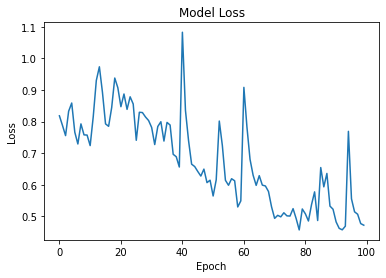

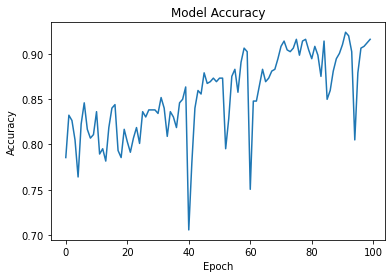

In [110]:
# Plot the training loss over time
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Plot the training accuracy over time
plt.plot(history.history['categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Model Architecture 

In [111]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 30, 64)            442112    
                                                                 
 dropout_23 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_28 (LSTM)              (None, 30, 128)           98816     
                                                                 
 dropout_24 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 64)               

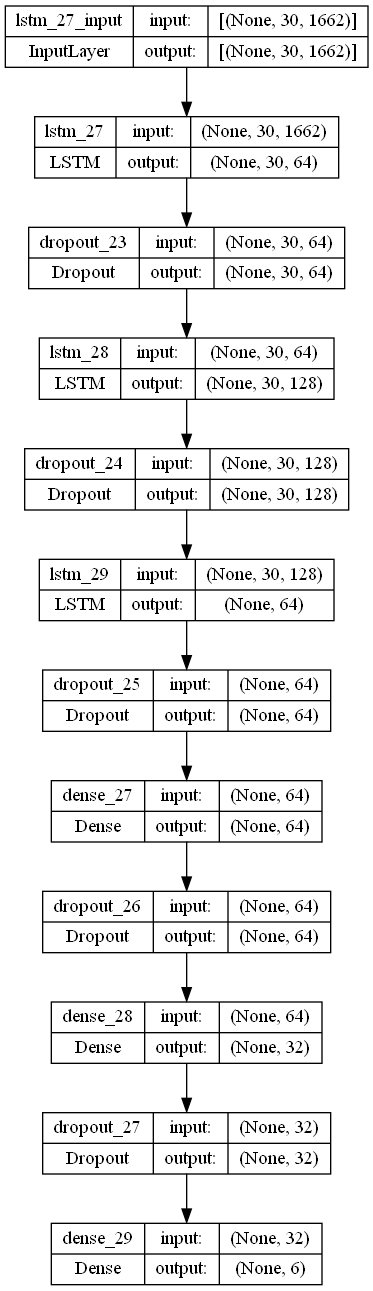

In [112]:
from tensorflow.keras.utils import plot_model

# Plot the model structure and save to a file
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)


In [66]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

1/1 [==============================] - 0s 112ms/step - loss: 0.3629 - categorical_accuracy: 0.9630
Test Loss: 0.3629028797149658
Test Accuracy: 0.9629629850387573


In [65]:
import numpy as np

# Get the predicted class probabilities for the test data
y_pred = model.predict(X_test)

# Get the predicted classes (i.e., the class with highest probability) for each test sample
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true classes for each test sample
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the accuracy for each action separately
actions = ['DrinkingWater', 'PushUps', 'Running', 'Squats', 'Walking', 'Standing']
for i, action in enumerate(actions):
    idx = np.where(y_true_classes == i)[0]
    accuracy = np.mean(y_pred_classes[idx] == y_true_classes[idx])
    print(f'Accuracy for {action}: {accuracy:.4f}')


1/1 [==============================] - 0s 110ms/step
Accuracy for DrinkingWater: 1.0000
Accuracy for PushUps: 1.0000
Accuracy for Running: 1.0000
Accuracy for Squats: 1.0000
Accuracy for Walking: 0.6667
Accuracy for Standing: 1.0000


In [114]:
res = model.predict(X_test)

1/1 [==============================] - 1s 752ms/step


In [115]:
actions[np.argmax(res[5])]

'PushUps'

## Save Model

In [116]:
actions[np.argmax(y_test[5])]

'PushUps'

In [155]:
model.save('action.h5')

In [156]:
del model

## Load Model 

In [161]:
model.load_weights('action.h5')

## Evaluation of the model

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
ypred = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# compute the confusion matrix
cm = confusion_matrix(ytrue, ypred)

# set the threshold for the color change (50% here)
threshold = cm.max() / 2.

# create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 8))

# plot the confusion matrix as an image with color-coded text labels
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > threshold else "black"
        ax.text(j, i, str(cm[i, j]), ha="center", va="center", color=color, fontsize=16)
ax.imshow(cm, cmap=plt.cm.Blues)

# set the x- and y-axis ticks and labels
ax.set_xticks(np.arange(len(actions)))
ax.set_yticks(np.arange(len(actions)))
ax.set_xticklabels(actions, rotation=45, ha="right", fontsize=14)
ax.set_yticklabels(actions, fontsize=14)

# set the x- and y-axis labels
ax.set_xlabel("Predicted Labels", fontsize=16)
ax.set_ylabel("True Labels", fontsize=16)

# set the title
ax.set_title("Confusion Matrix for All Actions", fontsize=18)

# add the colorbar
cbar = ax.figure.colorbar(ax.images[0], ax=ax)
cbar.ax.tick_params(labelsize=14)

# adjust the layout
plt.tight_layout()

# show the plot
plt.show()


In [ ]:
accuracy_score(ytrue, yhat)

## Predict from Video

In [162]:
from scipy import stats
import glob

In [163]:
colors = [(255, 87, 51), (199, 0, 57), (175, 51, 255), (255, 51, 82),  (0, 255, 255), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()

    # Get longest action name
    max_len = max([len(action) for action in actions])

    # Calculate box width based on longest action name
    box_width = max_len * 50 + 40

    # Calculate height and y-coordinate of the background rectangle
    rect_height = len(actions) * 120 + 40  # increase the height by 20 pixels
    rect_y = 40

    # Draw black rectangle as background for actions and probability
    #cv2.rectangle(output_frame, (20, rect_y), (box_width, rect_y + rect_height), (0, 0, 0), -1)

    for num, prob in enumerate(res):
        # Calculate width of box based on probability
        # Calculate width of colored box based on probability
        prob_width = int(prob * (box_width - 40))

        # Limit the probability width to the box width
        prob_width = min(prob_width, box_width)

        # Draw box for action
        cv2.rectangle(output_frame, (20, 100 + num * 120), (prob_width + 20, 200 + num * 120), colors[num], -1)

        # Add text for action and probability
        prob_str = f'{actions[num]}: {prob:.2f}'
        (text_width, text_height), _ = cv2.getTextSize(prob_str, cv2.FONT_HERSHEY_SIMPLEX, 2, 5)
        cv2.putText(output_frame, prob_str, (40, 160 + num * 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5, cv2.LINE_AA)

        # Draw colored background for text
        #cv2.rectangle(output_frame, (35, 105 + num * 120), (35 + text_width, 105 + text_height + num * 120), colors[num], -1)

    return output_frame


In [164]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions = ['DrinkingWater', 'PushUps', 'Running', 'Squats', 'Walking', 'Standing']


cap = cv2.VideoCapture()

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        # Get all video files for the current action
        video_files = glob.glob(f"videos/{action}*.mp4")
        for video_path in video_files:
            cap.open(video_path)

            # Get total number of frames in the video
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            while cap.isOpened():

                # Read feed
                ret, frame = cap.read()

                # Break the loop if end of the video is reached
                if cap.get(cv2.CAP_PROP_POS_FRAMES) == total_frames:
                    break

                # Make detections
                image, results = multiple_detection(frame, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # 2. Prediction logic
                keypoints = extract_keypoints(results)
                sequence.append(keypoints)
                sequence = sequence[-30:]

                if len(sequence) == 30:
                    res = model.predict(np.expand_dims(sequence, axis=0))[0]
                    print(actions[np.argmax(res)])
                    predictions.append(np.argmax(res))


                #3. Viz logic
                    if np.unique(predictions[-10:])[0]==np.argmax(res): 
                        if res[np.argmax(res)] > threshold: 

                            if len(sentence) > 0: 
                                if actions[np.argmax(res)] != sentence[-1]:
                                    sentence.append(actions[np.argmax(res)])
                            else:
                                sentence.append(actions[np.argmax(res)])

                    if len(sentence) > 5: 
                        sentence = sentence[-5:]

                    # Viz probabilities
                    image = prob_viz(res, actions, image, colors)

                #cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
                #cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                cv2.namedWindow('OpenCV Feed',cv2.WINDOW_NORMAL)
                cv2.resizeWindow('OpenCV Feed', (1280,720))
                # Show to screen
                cv2.imshow('OpenCV Feed', image)


                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            cap.release()
            cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 24ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
PushUps
<cla

1/1 [==============================] - 0s 25ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 45ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Squats
<cl

1/1 [==============================] - 0s 36ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Standing
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
PushUps
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
PushUps
<

1/1 [==============================] - 0s 29ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 37ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Squats
<class 'media

1/1 [==============================] - 0s 36ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Walking
<class 'medi

1/1 [==============================] - 0s 31ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
Squats
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
Squats
<class 'media